
<div class="alert alert-block alert-success">
    <center><b>Análise do Portifólio e Dados Econômicos/Financeiros</b></center>
</div>

In [1]:
import sgs
import pandas as pd
import matplotlib.pyplot as fig
import seaborn as sn
from datetime import date, timedelta
import yfinance as yf
from tabulate import tabulate
import statsmodels

In [2]:
## PARAMETROS ##
#inputs do usuário

dias = 600
acoes_b3 =  ['^BVSP', 'ITSA4.SA','BBDC4.SA','CCRO3.SA','PSSA3.SA',
          'TOTS3.SA', 'ENAT3.SA', 'AESB3.SA', 'HGLG11.SA'] 

In [3]:
# PARAMETROS - TRATAMENTO #
# alguns dados incluidos pela usuário precisam de tratamento

hoje = date.today() - timedelta(days=1)
final = hoje - timedelta(days=dias)


hoje_str = hoje.strftime('%d/%m/%Y')
final_str = final.strftime('%d/%m/%Y')

hoje_str_1 = hoje.strftime('%Y-%m-%d')
final_str_1 = final.strftime('%Y-%m-%d')

data_inicial = final_str
data_final =  hoje_str

dt_inicial = final_str_1
dt_final = hoje_str_1

In [4]:
# CAPTURA DOS DADOS E CRIAÇÃO DOS DATAFRAMES #

taxa_df = sgs.dataframe([4389,1178], start=data_inicial, end=data_final)
taxa_df.rename(columns = {4389: 'CDI %aa', 1178:'Selic %aa'}, inplace=True)
taxa_df.dropna(inplace=True)

moedas_df = sgs.dataframe([1,21619], start=data_inicial, end=data_final)
moedas_df.rename(columns = {1: 'Dolar Venda', 21619:'Euro Venda'}, inplace=True)
moedas_df['Paridade USD/EUR'] =  round(moedas_df['Dolar Venda'] / moedas_df['Euro Venda'] , 4)


indice_preco_df = sgs.dataframe([433,188,189], start=data_inicial, end=data_final)
indice_preco_df.rename(columns = {433: 'IPCA_am', 188:'INPC_am', 189:'IGP-M_am'}, inplace=True)

indice_preco_ipca_df = sgs.dataframe([433,13522], start=data_inicial, end=data_final)
indice_preco_ipca_df.rename(columns = {433: 'IPCA_am', 13522:'IPCA_Acum'}, inplace=True)

macro_df = sgs.dataframe([4381,28763], start=data_inicial, end=data_final)
macro_df.rename(columns = {4381: 'PIB_acum', 28763:'Emprego_total'}, inplace=True)


credito_df = sgs.dataframe([20635,20662], start=data_inicial, end=data_final)
credito_df.rename(columns = {20635: 'Credito_PJ', 20662:'Credito_PF'}, inplace=True)


tickers = yf.Tickers(acoes_b3)
ativos_df = pd.DataFrame(tickers.history(start = dt_inicial , end = dt_final))



[*********************100%***********************]  9 of 9 completed


In [5]:
## CÁLCULOS ##
#criação de dataframes com os dados resultado da manipulação dos dados cru

pd.set_option('use_inf_as_na', True)

moedas_df['MM20_Paridade'] = moedas_df['Paridade USD/EUR'].rolling(20).mean()
moedas_df['MM20_Dolar'] = moedas_df['Dolar Venda'].rolling(20).mean()
moedas_df['MM20_Euro'] = moedas_df['Euro Venda'].rolling(20).mean()



cdi_creditopf_df = pd.concat([taxa_df[['CDI %aa', 'Selic %aa']], credito_df ] , axis=1)
cdi_creditopf_df.dropna(inplace=True)

#Calcula o retorno dos ativos
ativos_df_retorno = ativos_df['Close'].pct_change()
ativos_df_retorno.dropna(inplace=True)


carteira_retorno_df = pd.DataFrame()
carteira_retorno_df['Carteira'] =  round ( ativos_df_retorno[list(acoes_b3[1:])].sum(axis=1).pct_change() , 2 )
carteira_retorno_df['Ibov'] = round ( ativos_df_retorno['^BVSP'].pct_change() , 2 )
carteira_retorno_df.dropna(how="all", inplace=True)


carteira_retorno_df_normalizado = pd.DataFrame()
carteira_retorno_df_normalizado['Carteira_Normalizada'] = carteira_retorno_df['Carteira'] / carteira_retorno_df['Carteira'].iloc[0]
carteira_retorno_df_normalizado['Ibov_Normalizada'] = carteira_retorno_df['Ibov'] / carteira_retorno_df['Carteira'].iloc[0]

In [6]:
# Outlaiers
carteira_retorno_df_sem_outlaiers = pd.DataFrame()

carteira_retorno_media = carteira_retorno_df['Carteira'].mean()
carteira_retorno_q1 = carteira_retorno_df['Carteira'].quantile(q=.25)
carteira_retorno_q3 = carteira_retorno_df['Carteira'].quantile(q=.75)
carteira_retorno_iqr = carteira_retorno_q3 - carteira_retorno_q1
carteira_retorno_Lsup = carteira_retorno_media + 1.5 * carteira_retorno_iqr
carteira_retorno_Linf = carteira_retorno_media - 1.5 * carteira_retorno_iqr

carteira_retorno_df_sem_outlaiers['Retorno'] = carteira_retorno_df['Carteira'][ ( carteira_retorno_df['Carteira'] > carteira_retorno_Linf
                                                                    ) & (carteira_retorno_df['Carteira'] < carteira_retorno_Lsup) ]


carteira_retorno_df_sem_outlaiers['Carteira_retorno_Lsup'] = carteira_retorno_Lsup
carteira_retorno_df_sem_outlaiers['Carteira_retorno_Linf'] = carteira_retorno_Linf

 


In [8]:
# Calcula as correlações 

correlacao_ativos_df = ativos_df_retorno.corr(method = 'pearson')
correlacao_carteira_df = carteira_retorno_df.corr(method = 'pearson')

<div class="alert alert-block alert-success">
    <b>Contrução do Relatório</b>
</div>


In [9]:
# RELATORIO - APRESENTAÇÃO DOS DADOS

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


rept = 20
t1 = 'DADOS DO PORTIFOLIO'
t2 = 'GRÁFICOS'
t3 = ' --- Dados Ecônomicos --- '

print('*' * rept)
print(t1.center(rept))
print('*' * rept)
print(hoje_str.rjust(rept))

********************
DADOS DO PORTIFOLIO 
********************
          16/04/2023




 --- Dados Ecônomicos --- 
10 últimas taxas:
+---------------------+---------+-----------+
|                     | CDI %aa | Selic %aa |
+---------------------+---------+-----------+
| 2023-03-31 00:00:00 |  13.65  |   13.65   |
| 2023-04-03 00:00:00 |  13.65  |   13.65   |
| 2023-04-04 00:00:00 |  13.65  |   13.65   |
| 2023-04-05 00:00:00 |  13.65  |   13.65   |
| 2023-04-06 00:00:00 |  13.65  |   13.65   |
| 2023-04-10 00:00:00 |  13.65  |   13.65   |
| 2023-04-11 00:00:00 |  13.65  |   13.65   |
| 2023-04-12 00:00:00 |  13.65  |   13.65   |
| 2023-04-13 00:00:00 |  13.65  |   13.65   |
| 2023-04-14 00:00:00 |  13.65  |   13.65   |
+---------------------+---------+-----------+




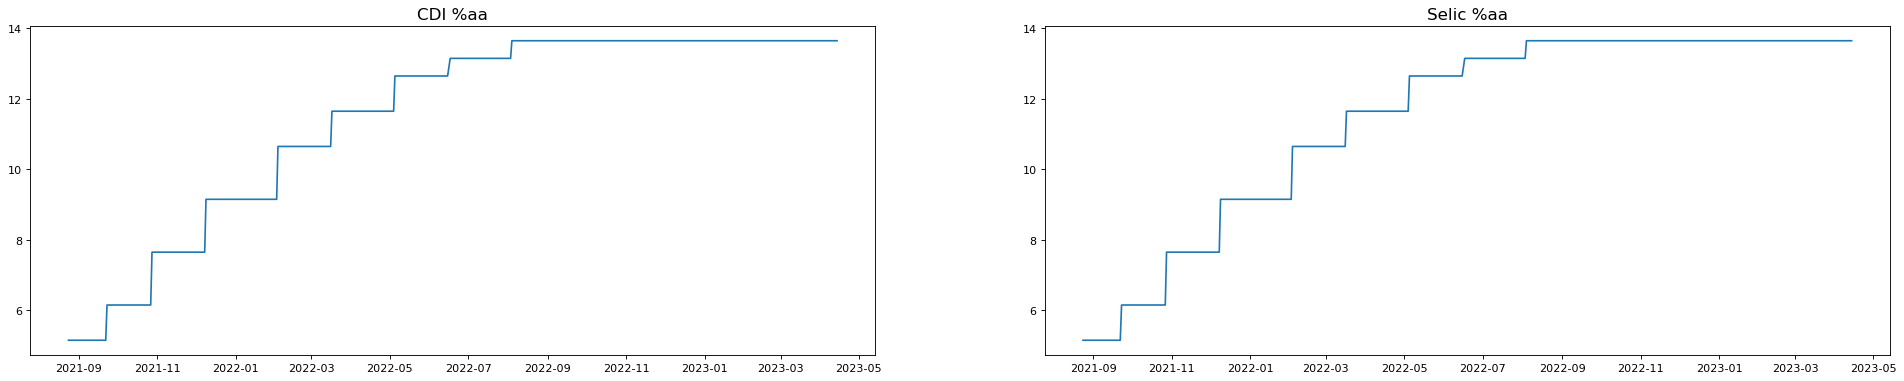

In [10]:
print('\n')
print(t3.center(rept))


print('10 últimas taxas:')
print(tabulate(taxa_df.tail(10), list(taxa_df), tablefmt="pretty"))
print('\n')


fig.figure(figsize=(30, 12), dpi=80)


fig.subplot(221)
fig.title('CDI %aa', fontsize=15)
fig.plot(taxa_df['CDI %aa'])

fig.subplot(222)
fig.title('Selic %aa', fontsize=15)
fig.plot(taxa_df['Selic %aa'])






Moedas:
+---------------------+-------------+------------+------------------+
|                     | Dolar Venda | Euro Venda | Paridade USD/EUR |
+---------------------+-------------+------------+------------------+
| 2023-03-03 00:00:00 |   5.2037    |   5.5159   |      0.9434      |
| 2023-03-06 00:00:00 |    5.197    |   5.5509   |      0.9362      |
| 2023-03-07 00:00:00 |   5.1901    |   5.4948   |      0.9445      |
| 2023-03-08 00:00:00 |   5.1387    |   5.4244   |      0.9473      |
| 2023-03-09 00:00:00 |   5.1353    |   5.4285   |      0.946       |
| 2023-03-10 00:00:00 |   5.1822    |   5.5393   |      0.9355      |
| 2023-03-13 00:00:00 |    5.24     |   5.623    |      0.9319      |
| 2023-03-14 00:00:00 |   5.2362    |   5.6148   |      0.9326      |
| 2023-03-15 00:00:00 |   5.2981    |   5.5821   |      0.9491      |
| 2023-03-16 00:00:00 |   5.2892    |   5.6192   |      0.9413      |
| 2023-03-17 00:00:00 |   5.2679    |   5.6093   |      0.9391      |
| 2023-03-

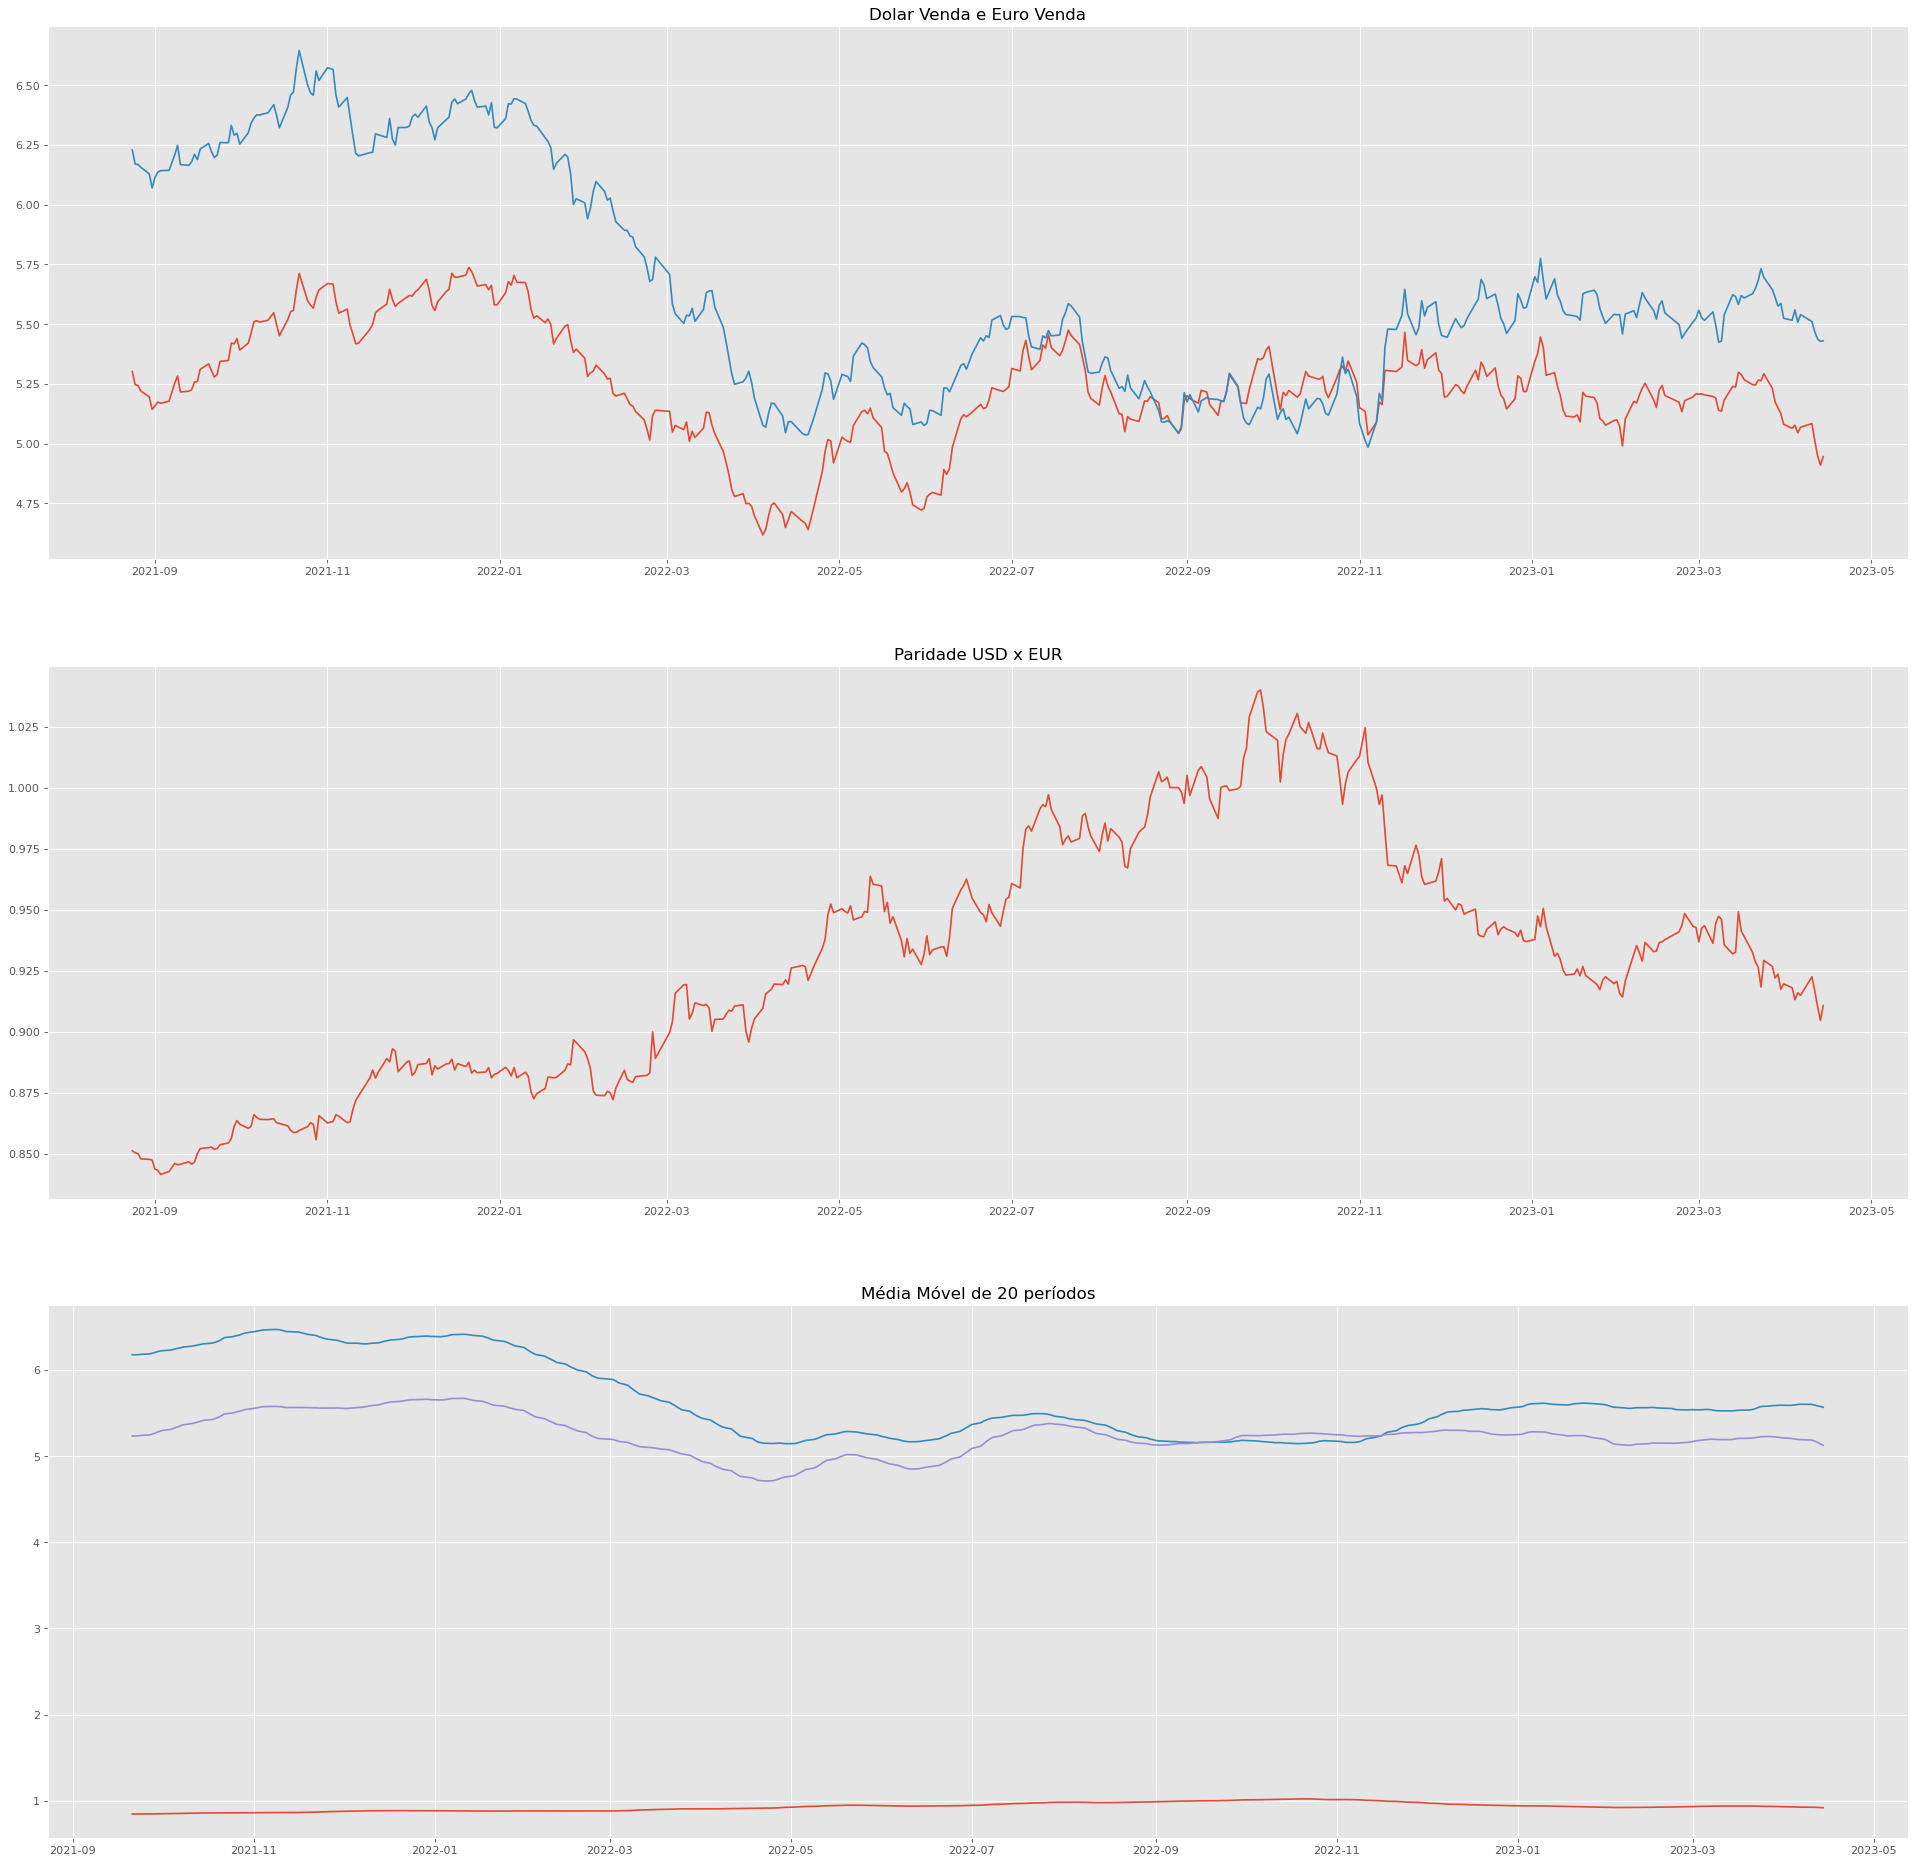

In [11]:
print('\n')
print('Moedas:')
print(tabulate(moedas_df[['Dolar Venda', 'Euro Venda','Paridade USD/EUR']].tail(30), 
               ['Dolar Venda', 'Euro Venda','Paridade USD/EUR'],  tablefmt="pretty" ))


fig.style.use('ggplot')
fig.figure(figsize=(30, 30), dpi=80)

fig.subplot(311)
fig.title('Dolar Venda e Euro Venda', fontsize=15)
fig.plot(moedas_df[['Dolar Venda', 'Euro Venda']])

fig.subplot(312)
fig.title('Paridade USD x EUR', fontsize=15)
fig.plot(moedas_df['Paridade USD/EUR'])


fig.subplot(313)
fig.title('Média Móvel de 20 períodos', fontsize=15)
fig.plot(moedas_df[['MM20_Paridade', 'MM20_Euro', 'MM20_Dolar']])



<AxesSubplot:>

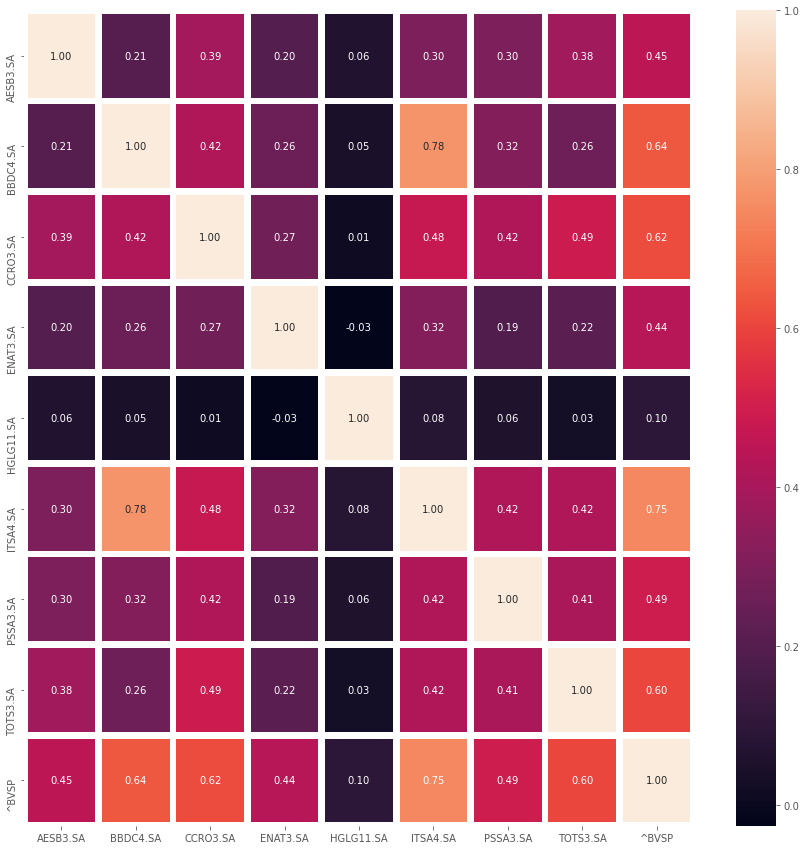

In [12]:
# Mapa de calor das correlações

fig.figure(figsize = (15,15))
sn.heatmap(correlacao_ativos_df, annot = True, fmt = '.2f', linewidths = 6)


Retorno da Carteira e IBOV
+---------------------+----------+--------+
|                     | Carteira |  Ibov  |
+---------------------+----------+--------+
| 2023-03-17 00:00:00 |  -5.71   |  -2.9  |
| 2023-03-20 00:00:00 |  -0.33   | -0.26  |
| 2023-03-21 00:00:00 |   -1.3   | -1.07  |
| 2023-03-22 00:00:00 |   0.36   | -11.35 |
| 2023-03-23 00:00:00 |  -6.77   |  1.98  |
| 2023-03-24 00:00:00 |  -1.55   |  -1.4  |
| 2023-03-27 00:00:00 |  -0.36   | -0.08  |
| 2023-03-28 00:00:00 |  -0.04   |  0.79  |
| 2023-03-29 00:00:00 |  -1.85   |  -0.6  |
| 2023-03-30 00:00:00 |  -3.38   |  2.14  |
| 2023-03-31 00:00:00 |   -1.0   | -1.94  |
| 2023-04-03 00:00:00 |  349.12  | -0.79  |
| 2023-04-04 00:00:00 |  -2.56   | -1.97  |
| 2023-04-05 00:00:00 |  -1.39   | -3.45  |
| 2023-04-06 00:00:00 |  -0.39   | -0.82  |
| 2023-04-10 00:00:00 |  -2.64   | -7.58  |
| 2023-04-11 00:00:00 |   2.52   |  3.22  |
| 2023-04-12 00:00:00 |  -0.42   | -0.85  |
| 2023-04-13 00:00:00 |  -1.07   | -1.64  |
| 202

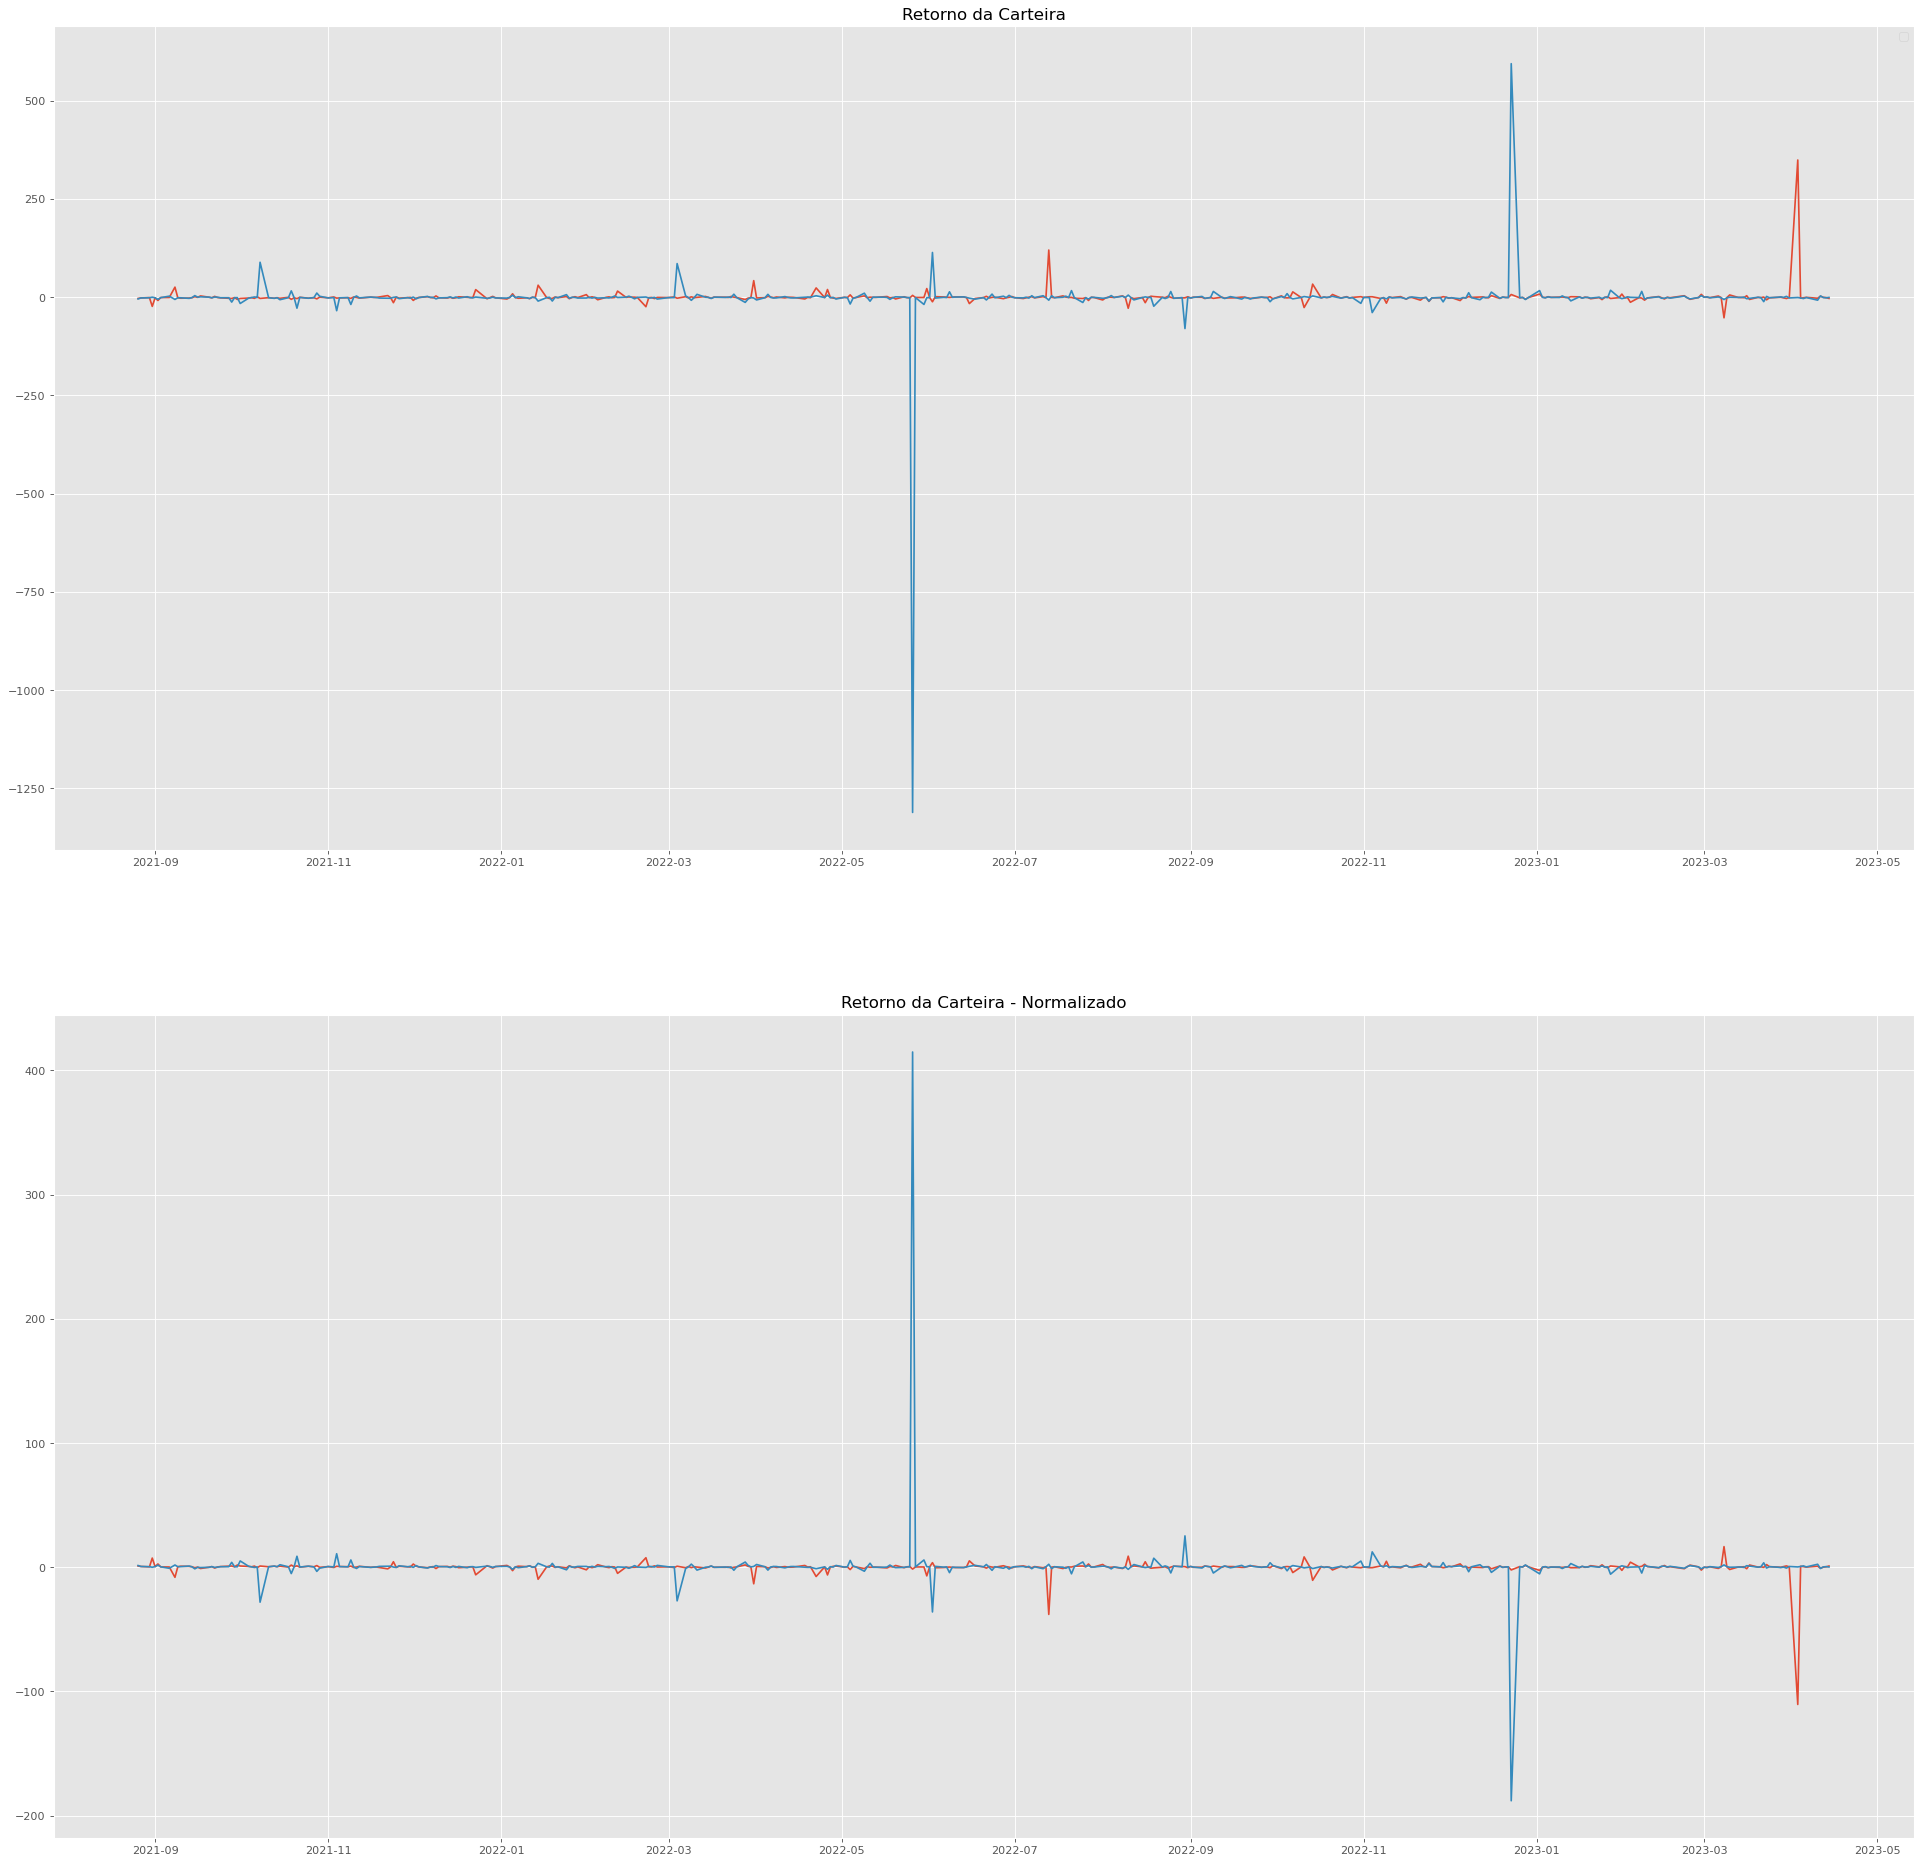

In [13]:
print('Retorno da Carteira e IBOV')
print(tabulate(carteira_retorno_df.tail(20), list(carteira_retorno_df), tablefmt="pretty"))
print('\n')
print(carteira_retorno_df.describe())



# Grafico
fig.figure(figsize=(30, 30), dpi=80)

fig.subplot(211)
fig.title('Retorno da Carteira', fontsize=15)
fig.legend(list(carteira_retorno_df))
fig.plot(carteira_retorno_df)



fig.subplot(212)
fig.title('Retorno da Carteira - Normalizado', fontsize=15)
fig.plot(carteira_retorno_df_normalizado)

count    306.000000
mean      -0.520719
std        1.171331
min       -2.600000
25%       -1.287500
50%       -0.715000
75%        0.077500
max        3.270000
Name: Retorno, dtype: float64


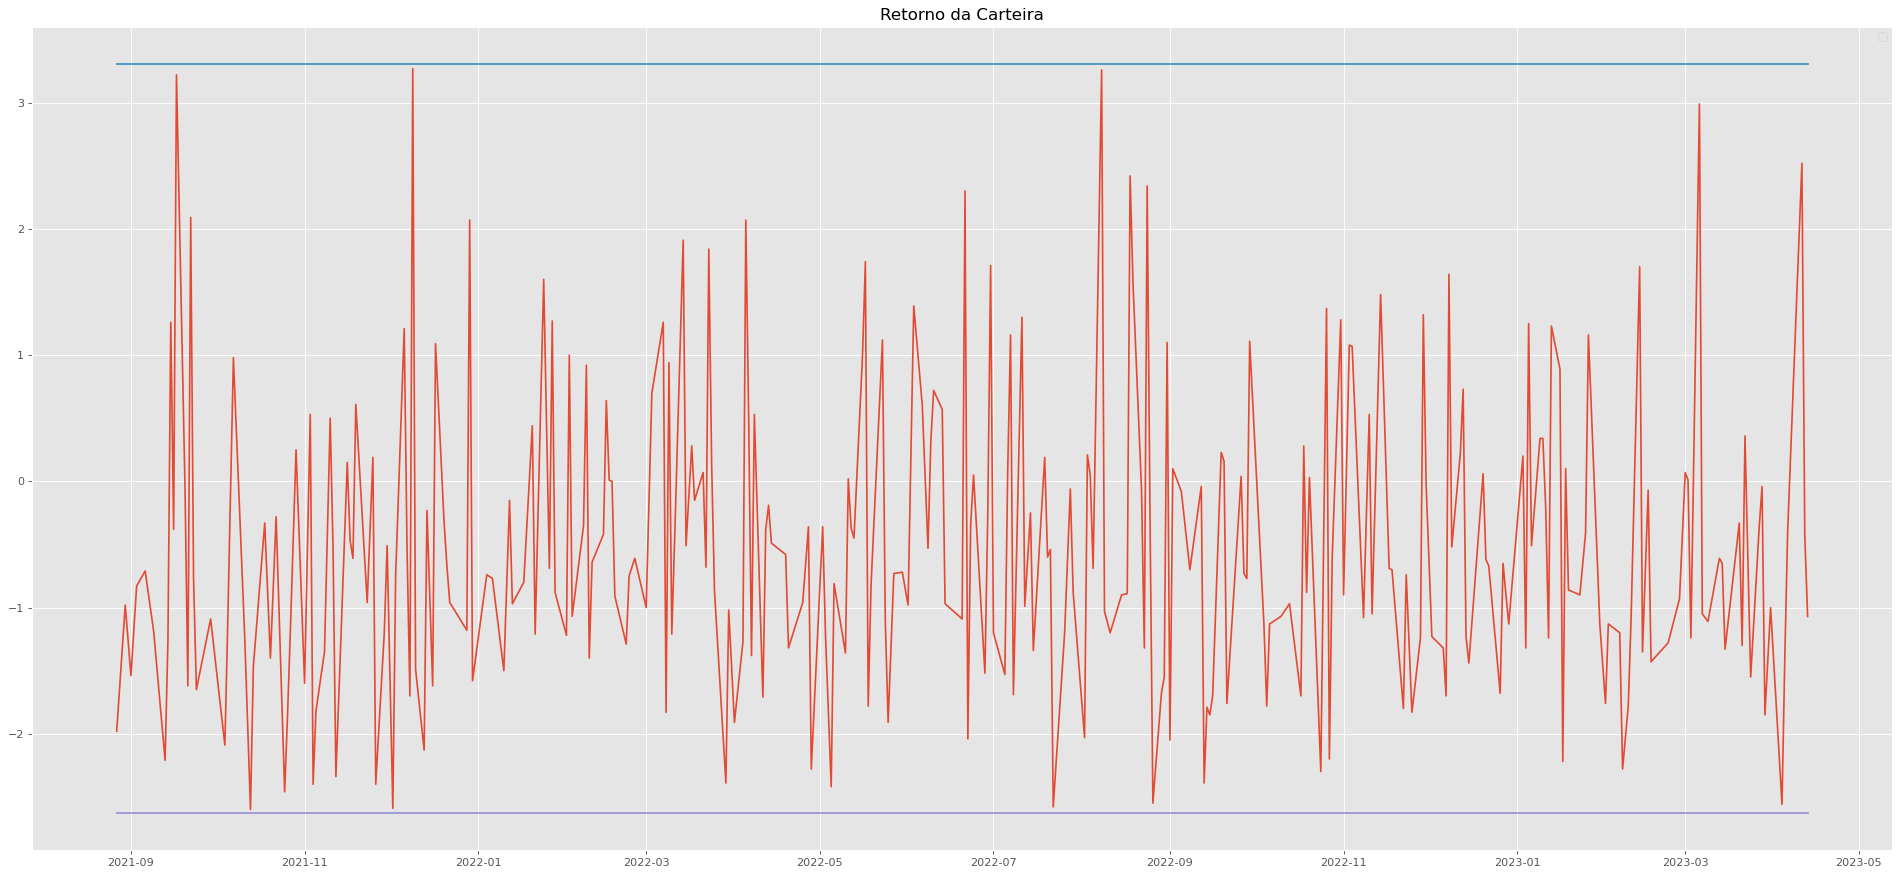

In [14]:

print(carteira_retorno_df_sem_outlaiers['Retorno'].describe())

fig.figure(figsize=(30, 30), dpi=80)
fig.subplot(211)
fig.title('Retorno da Carteira', fontsize=15)
fig.legend(list(carteira_retorno_df_sem_outlaiers))
fig.plot(carteira_retorno_df_sem_outlaiers)
